# Step 1. Download data and prepare it for analysis
Load data about visits, orders and expenses into variables. Optimizing data for analysis. Making sure the data type in each column is correct. File path:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
visits  = pd.read_csv('/datasets/visits_info_short.csv')
orders =  pd.read_csv('/datasets/orders_info_short.csv')
costs  =   pd.read_csv('/datasets/costs_info_short.csv')


visits['Session Start'] = pd.to_datetime(visits['Session Start'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
visits.rename(columns = {'Session Start':'session_start', 'User Id':'user_id','Channel':'channel','Device':'device','Region':'region', 'Session End': 'session_end'}, inplace = True)
orders.rename(columns = {'User Id':'user_id', 'Event Dt':'event_dt','Revenue':'revenue'}, inplace = True)
costs.rename(columns = {'Channel':'channel'}, inplace = True)


In [2]:
print(visits.head(1))
print(orders.head(1))
print(costs.head(1))

        user_id         region  device  channel       session_start  \
0  981449118918  United States  iPhone  organic 2019-05-01 02:36:01   

           session_end  
0  2019-05-01 02:45:01  
        user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
           dt   channel  costs
0  2019-05-01  FaceBoom  113.3


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 14.2+ MB


In [4]:
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [5]:
# missing values
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [6]:
orders.isna().sum()


user_id     0
event_dt    0
revenue     0
dtype: int64

In [7]:
costs.isna().sum()


dt         0
channel    0
costs      0
dtype: int64

In [8]:
# duplicates
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()


0

# Step 2. We set functions for calculating and analyzing LTV, ROI, retention and conversion


In [11]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

   # find the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for cohort analysis, determine the date of the first visit
    # and the first day of the month in which this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

   # add a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # add flags for all events from event_names
    

    # count the number of unique users
    # with the same source and date of attraction
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # combine spending on advertising and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # divide advertising costs by the number of attracted users
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # organic user acquisition cost is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

   # add the payer column to the passed dimensions list
    dimensions = ['payer'] + dimensions

   # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

   # collecting raw data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

   # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get hold table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # get a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time 

In [13]:
# get user profiles
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
profiles = get_profiles(visits, orders,costs)
print(profiles.head(1)) 
       

   user_id            first_ts   channel device         region          dt  \
0   599326 2019-05-07 20:58:57  FaceBoom    Mac  United States  2019-05-07   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  


In [14]:
# get retention
from datetime import datetime,timedelta
observation_date = profiles['dt'].max()  # moment of analysis
analysis_horizon = 7                     # analysis horizon
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon
)
print(retention.head(3))

       cohort_size    0         1         2         3         4         5  \
payer                                                                       
False       135866  1.0  0.176704  0.086357  0.051455  0.034549  0.024568   
True          8542  1.0  0.404706  0.316905  0.260009  0.227347  0.208382   

              6  
payer            
False  0.018518  
True   0.187193  


In [15]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
   # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
        # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
   # remove 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions:
        dimensions = []

    # get a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [16]:
conversion_raw, conversion,conversion_history =  get_conversion(
    profiles,
    orders,
    observation_date,
    analysis_horizon
)


In [17]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
# exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # add purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function according to the desired features
    
    def group_by_dimensions(df, dims, horizon_days):
        # build a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # find the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculate LTV: divide each "cell" in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes
# collect dataframe with user data and CAC values,
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculate the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        
        # restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # add CAC to ROI table
        roi['cac'] = cac['cac']

        # in the final table we leave the sizes of cohorts, CAC
        # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # return LTV and ROI tables
        return result, roi

    # get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw, # raw data
        result_grouped, # LTV table
        result_in_time, # LTV dynamics table
        roi_grouped, # ROI table
        roi_in_time, # ROI dynamics table
    )

In [18]:
def filter_data(df, window):
   # apply a moving average for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [19]:
def plot_retention(retention, retention_history, horizon, window=7):

   # set the grid size for charts

    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # leave only the desired lifetime in the dynamics table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

   # if there is only payer in the indexes of the hold table,
    # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # in the graph table - two columns and two rows, four cells
    # in the first we build retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # in the second cell we build non-paying retention curves
    # vertical axis - from the graph from the first cell
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of not paying users')

    # in the third cell - the dynamics of retention of paying
    ax3 = plt.subplot(2, 2, 3)
    # get the column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter data and plot
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of attraction')
    plt.title(
        'Dynamics of retention of paying users on {} day'.format(
            horizon
        )
    )

  # in the fourth cell - the dynamics of retention of non-paying
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter data and plot
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of attraction')
    plt.title(
        'Dynamics of retention of paying users on {} day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [20]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # set the grid size for charts
    plt.figure(figsize=(15, 5))

    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the dynamics table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first chart - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Conversion of users')

    # second graph - conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # all index columns except date will become pivot table columns
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of user conversion on {} day'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [21]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
# set the grid for drawing charts
    plt.figure(figsize=(20, 10))

    # exclude cohort sizes from table ltv
    ltv = ltv.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the ltv dynamics table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # write the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]

    # exclude cohort sizes and cac from table roi
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # leave only the desired lifetime in the roi dynamics table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

   # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

   # second graph - ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of LTV users on {} day'.format(horizon))
   
    # the third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of the cost of attracting users')

   # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Level of return on investment')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

   # the fifth graph is the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all index columns except date will become pivot table columns
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of  ROI users on {} day'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Step 3. Conduct an exploratory data analysis

Let's build user profiles. Determine the minimum and maximum date for attracting users.

Let's find out:
- What countries do the visitors come from? Which countries have the most paying users?
- What devices do they use? What devices do paying users visit most often?
- What advertising channels did you use to attract users? Which channels bring in the most paying users?

In [22]:
print(profiles['first_ts'].min()) # the minimum user acquisition date is May 1
print(profiles['first_ts'].max()) # the maximum user acquisition date is October 27

2019-05-01 00:00:41
2019-10-27 23:59:04


In [23]:
import seaborn as sns
observation_date = profiles['dt'].max() # moment of analysis
analysis_horizon = 7                     # analysis horizon

<AxesSubplot:xlabel='region', ylabel='all_users'>

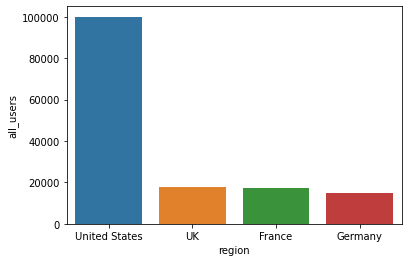

In [24]:
d = profiles.groupby('region').agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
d.rename(columns={'user_id':'all_users'},inplace=True)
sns.barplot(x='region',y='all_users',data=d)

<AxesSubplot:xlabel='region', ylabel='pay_users'>

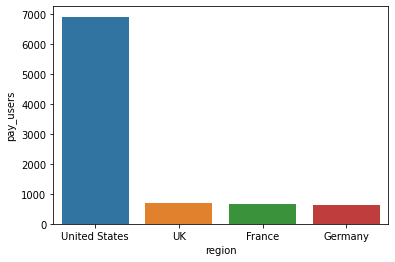

In [25]:
only_payers = profiles.query('payer==True')
da =  only_payers.groupby('region').agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
da.rename(columns={'user_id':'pay_users'},inplace=True)
sns.barplot(x='region',y='pay_users',data=da)

In [26]:
table_by_region = d.merge(da, on='region',how='left')
table_by_region['%pay_users'] = (table_by_region['pay_users']/table_by_region['all_users'])*100
table_by_region.sort_values(by='%pay_users',ascending=False)

,region,all_users,pay_users,%pay_users
0,United States,100002,6902,6.901862
3,Germany,14981,616,4.111875
1,UK,17575,700,3.982930
2,France,17450,663,3.799427


There are many more users from the USA than users from other countries, and there are also many more paying users. These are our main clients.

<AxesSubplot:xlabel='device', ylabel='all_users'>

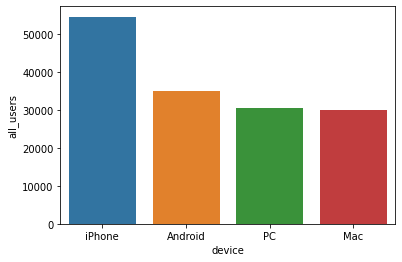

In [27]:
l = profiles.groupby('device').agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
l.rename(columns={'user_id':'all_users'},inplace=True)
sns.barplot(x='device',y='all_users',data=l)

<AxesSubplot:xlabel='device', ylabel='pay_users'>

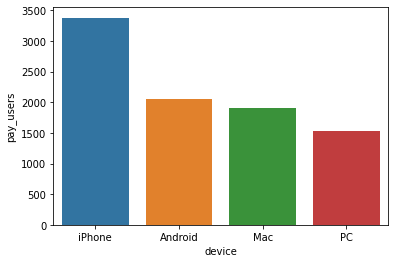

In [28]:
la = only_payers.groupby('device').agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
la.rename(columns={'user_id':'pay_users'},inplace=True)
sns.barplot(x='device',y='pay_users',data=la)

In [29]:
table_by_device = l.merge(la, on='device',how='left')
table_by_device['%pay_users'] = (table_by_device['pay_users']/table_by_device['all_users'])*100
table_by_device.sort_values(by='%pay_users',ascending=False)

,device,all_users,pay_users,%pay_users
3,Mac,30042,1912,6.364423
0,iPhone,54479,3382,6.207897
1,Android,35032,2050,5.851793
2,PC,30455,1537,5.046790


Most paying users come from iPhone, but paying users are more on Mac

In [30]:
c = profiles.groupby('channel').agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
c.rename(columns={'user_id':'all_users'},inplace=True)

In [31]:
ca = only_payers.groupby('channel').agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).reset_index()
ca.rename(columns={'user_id':'pay_users'},inplace=True)

In [32]:
table_by_channel = c.merge(ca, on='channel',how='left')
table_by_channel['%pay_users'] = (table_by_channel['pay_users']/table_by_channel['all_users'])*100
table_by_channel.sort_values(by='%pay_users',ascending=False)

,channel,all_users,pay_users,%pay_users
1,FaceBoom,29144,3557,12.204914
9,AdNonSense,3880,440,11.340206
10,lambdaMediaAds,2149,225,10.469986
2,TipTop,19561,1878,9.600736
6,RocketSuperAds,4448,352,7.913669
5,WahooNetBanner,8553,453,5.296387
8,YRabbit,4312,165,3.826531
7,MediaTornado,4364,156,3.574702
4,LeapBob,8553,262,3.063253
3,OppleCreativeMedia,8605,233,2.707728


Most users found the application themselves, but those who stayed and started paying are also very few - about 2%. Most of the paying users came from 'Faceboom' - and the conversion there is 12%. Maybe buy more ads from this channel.

# Step 4. Marketing

Let's find out:
- How much money did you spend? Total / per source / by time
- How much did it cost on average to attract one buyer from each source?

In [33]:
# how much money was spent
print(profiles['acquisition_cost'].sum()) # всего на расходы было потрачено 105497$.

105497.29999999999


In [34]:
cost_by_channel = profiles.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)
cost_by_channel


channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
organic                   0.00
Name: acquisition_cost, dtype: float64

Most of the money was spent on advertising in Tiptop, although the conversion rate for this channel is less than that of FaceBoom by almost 5%.

In [35]:
cost_by_date = profiles.groupby('month')['acquisition_cost'].sum().sort_values(ascending=False)
cost_by_date  

month
2019-09-01    22441.340
2019-10-01    20882.415
2019-08-01    20657.870
2019-07-01    16447.060
2019-06-01    15090.045
2019-05-01     9978.570
Name: acquisition_cost, dtype: float64

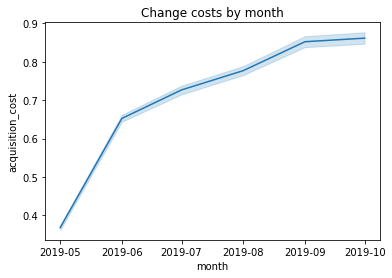

In [36]:
# visualize the change in metrics over time
import matplotlib.pyplot as plt
sns.lineplot(x='month',y='acquisition_cost',data=profiles)
plt.title('Change costs by month')
plt.show()

Expenses have increased dramatically in these months.

In [37]:
profiles = profiles.query('channel != "organic"')

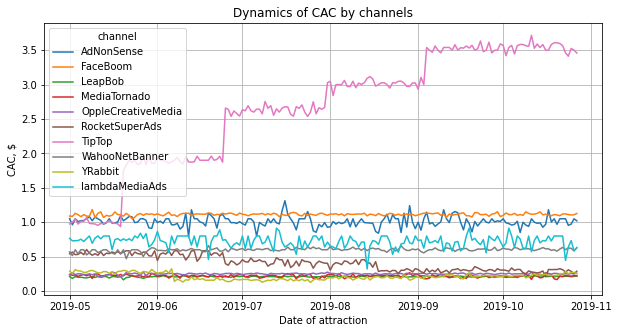

In [38]:
# visualize the change in metrics over time with distribution by channels
import numpy as np
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Date of attraction')
plt.title('Dynamics of CAC by channels')
plt.show()

'Tiptop' is very off-putting compared to the others.

In [39]:
cost_by_device =  profiles.groupby('device')['acquisition_cost'].sum().sort_values(ascending=False)

Most of all was spent in September and October, which is probably why the business has been losing money over the past two months

In [40]:
# see where the most money was invested in the last 3 months
last_month = profiles.query('month=="2019-09-01" or month=="2019-10-01" or month=="2019-08-01"')


In [41]:
cost_by_channel = last_month.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)
cost_by_channel

channel
TipTop                36684.500
FaceBoom              18125.800
WahooNetBanner         2959.800
AdNonSense             1698.900
OppleCreativeMedia     1245.000
LeapBob                1029.210
lambdaMediaAds          680.800
RocketSuperAds          677.235
YRabbit                 440.940
MediaTornado            439.440
Name: acquisition_cost, dtype: float64

Over the past 3 months, a lot of money has been invested in the acquisition channel 'Tiptiop', which did not give such a good conversion. Perhaps this was a mistake.

In [42]:
# average CAC per user
print(profiles['acquisition_cost'].mean())

1.1274813239427588


In [43]:
# average CAC per user by traffic source
g = profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)
g

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

# Step 5. Estimate the ROI of advertising to attract users

With LTV and ROI:
- Analyze the overall payback of advertising;
- Analyze the payback of advertising by device;
- Analyze the payback of advertising by country;
- Let's analyze the payback of advertising with a breakdown by advertising channels.

Let's describe the problems you found. Answer the questions:
- Does advertising aimed at attracting users in general pay off?
- What devices, countries and advertising channels can have a negative impact on advertising ROI?
- What can cause payback problems? Explore conversion and retention by device, country, advertising channel.

We will describe the possible causes of the detected problems and form recommendations for the advertising department.

### Let's analyze the total return on advertising

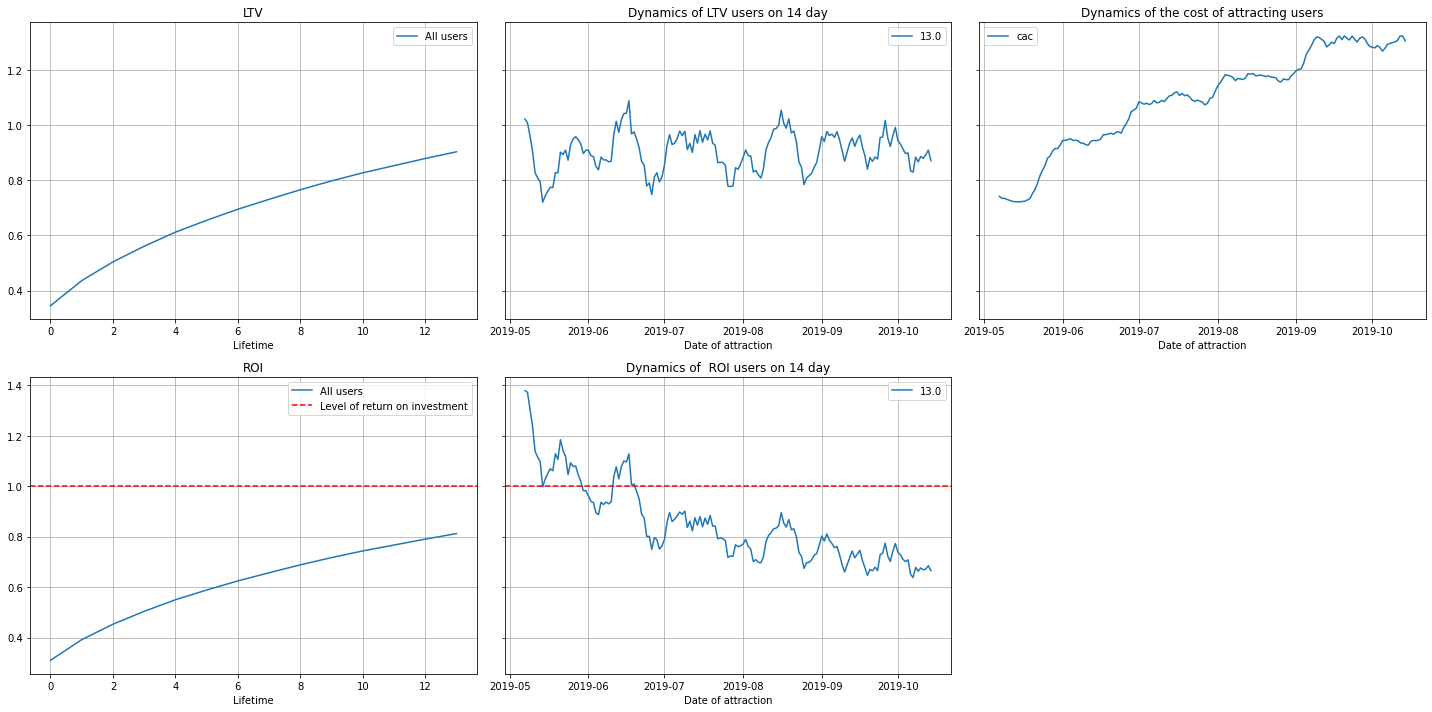

In [44]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, 14,
)
 # exclude cohort sizes and CACs from ROI table

# build ROI curves
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

If we look at ROI, we will see that advertising does not pay off. We need to figure out what's wrong.

### Let's analyze the payback of advertising by device

In [45]:
# see what devices users use more often.
l

,device,all_users
0,iPhone,54479
1,Android,35032
2,PC,30455
3,Mac,30042


In [46]:
# view ad spend by device
cost_by_device.sort_values(ascending=False)

device
iPhone     43678.788251
Mac        24094.537878
Android    22460.629159
PC         15263.344712
Name: acquisition_cost, dtype: float64

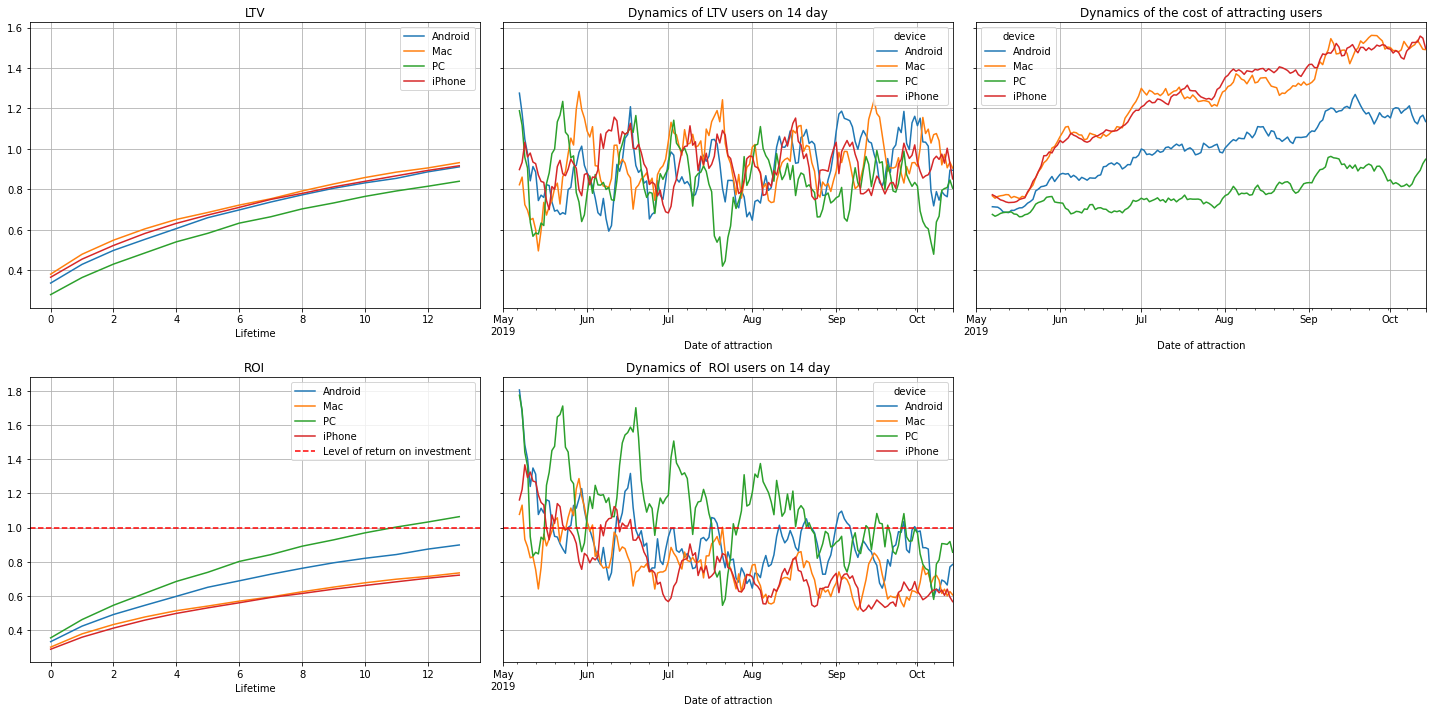

In [47]:
# ltv and roi by device
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, 14,dimensions=['device']
)
 # exclude cohort sizes and CACs from ROI table

# build ROI curves
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

PC users bring the least profit, but due to the fact that they spend the least money on them, this is the most profitable device.
It might be worth reducing the cost of advertising for the iPhone.

### Let's analyze the payback of advertising by country

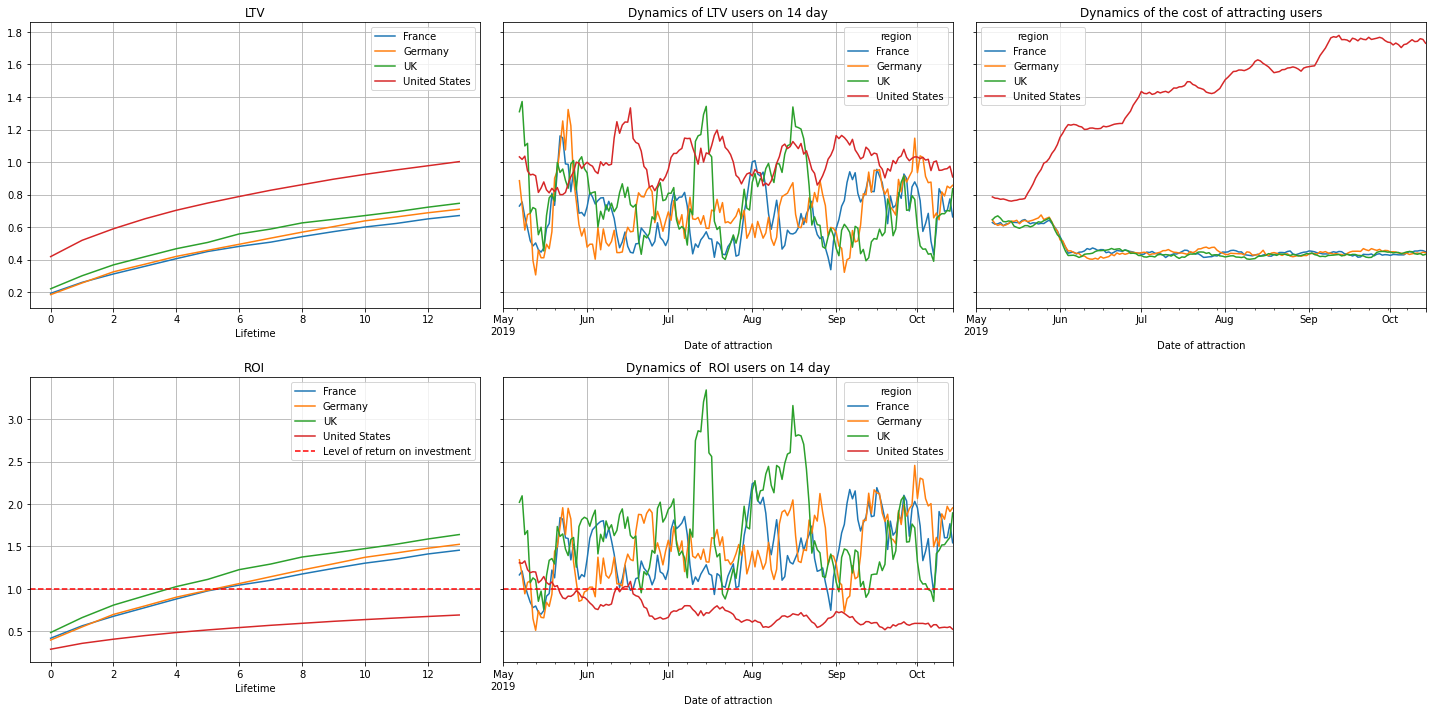

In [48]:
# ltv and roi by country
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, 14,dimensions=['region']
)
# exclude cohort sizes and CACs from ROI table

# build ROI curves
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

The situation is the same with a breakdown by country. The total profit from America is greater than from other countries. But due to the fact that many times more money is spent on expenses and on advertising, this is the only country that ultimately did not pay off. Most of our clients are from the USA.

### Let's analyze the payback of advertising by advertising channels

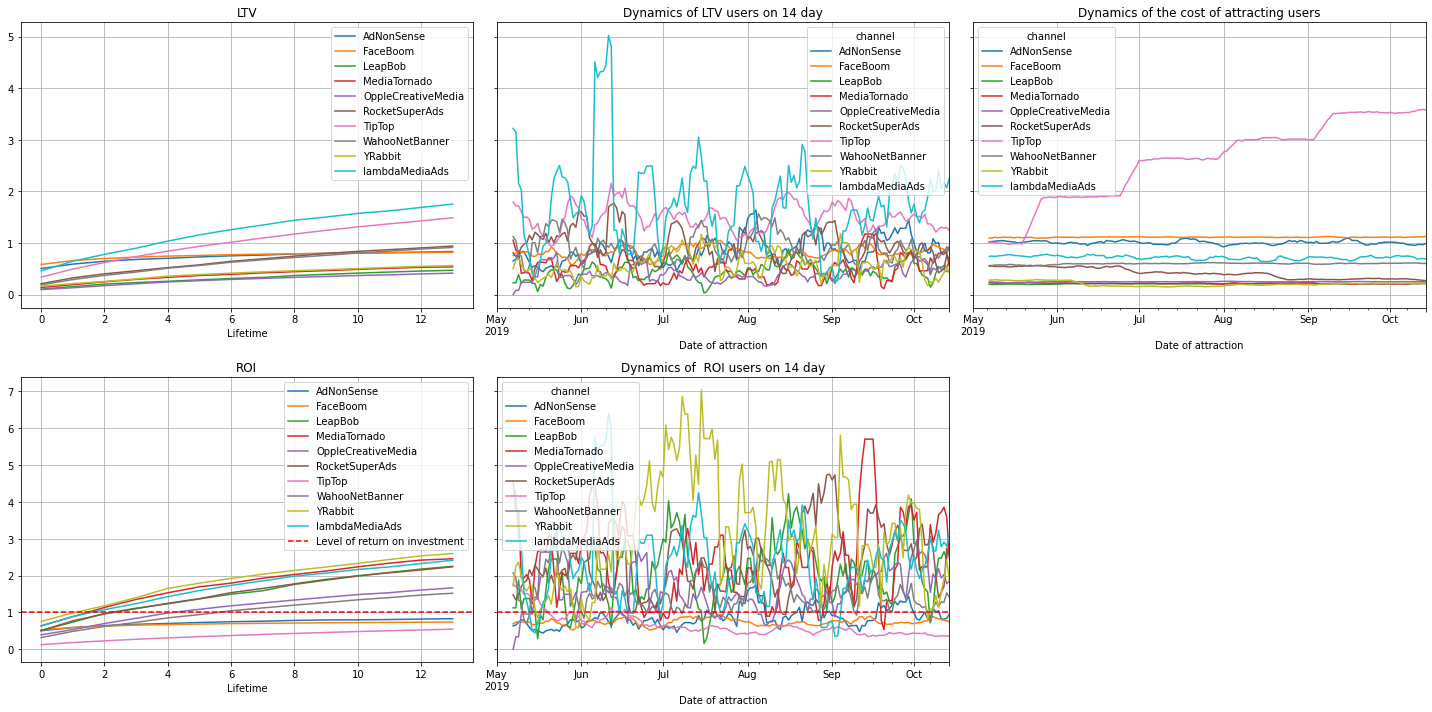

In [49]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, 14,dimensions=['channel']
)
 # exclude cohort sizes and CACs from ROI table

# build ROI curves
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

From the 'User Acquisition Cost Trends', it can be seen that a lot of money was invested in the 'Tip Top' channel, which did not deliver very good conversions and retention, making it the worst ROI. The 'lambdaMediaAds' channel is the most profitable channel, because it is not so expensive in terms of costs, it pays off well. And 'YRAbbit' channel is in the first place in terms of payback, as it is very cheap in terms of advertising. Might be worth investing in 'lambdaMediaAds' rather than 'Tiptop'

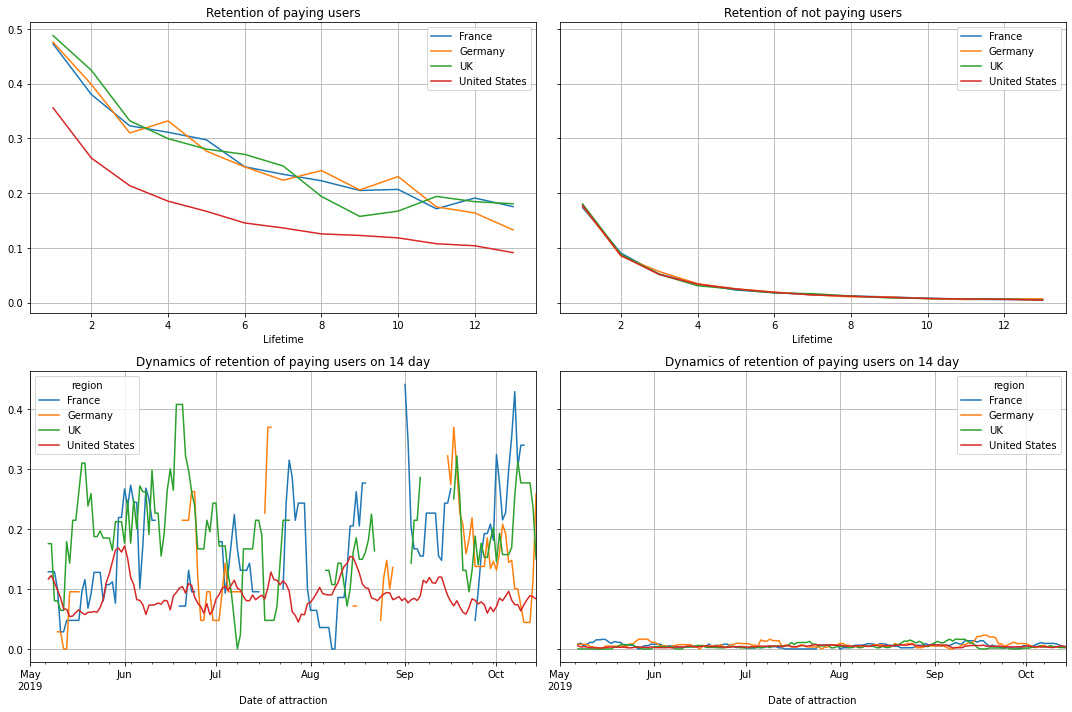

In [50]:
# user retention by country
retention_raw,retention,retention_history=get_retention(
    profiles,
    visits,
    observation_date,
    14,
    dimensions=['region'])
plot_retention(retention, retention_history, 14, window=7)

Although there are many more paying users from the US, they are the worst retained. Although there is logic in this.

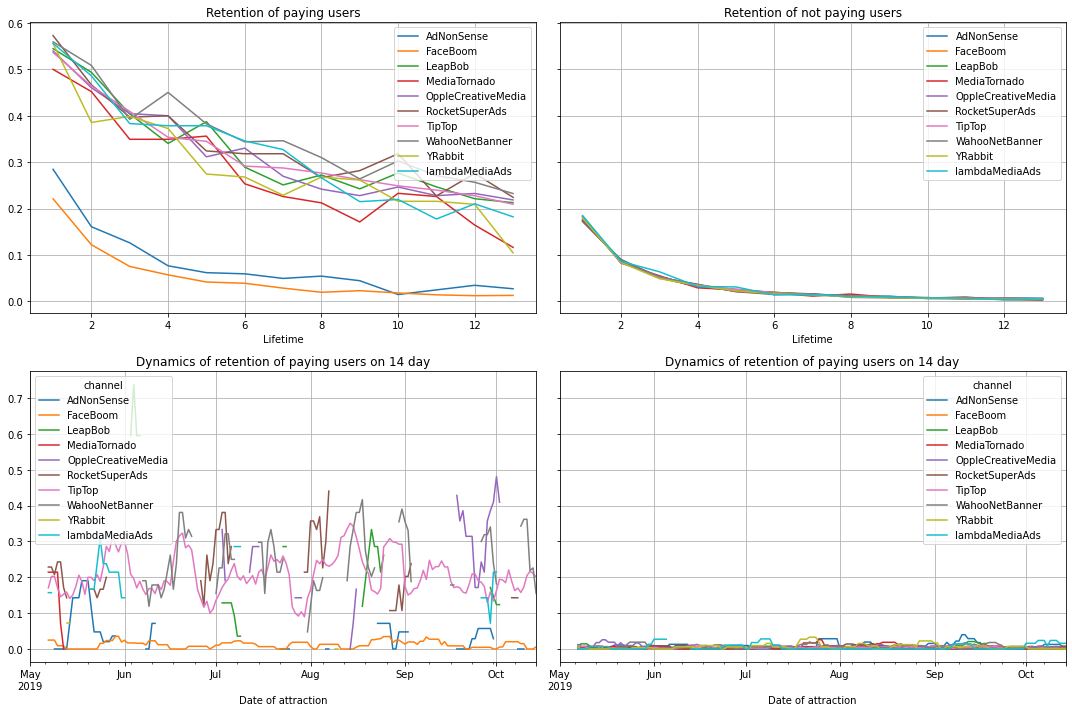

In [51]:
# user retention through acquisition channels
retention_raw,retention,retention_history=get_retention(
    profiles,
    visits,
    observation_date,
    14,
    dimensions=['channel'])
plot_retention(retention, retention_history, 14, window=7)

Same logic with the 'Faceboom' attraction channel. The more users come, the worse they are retained. But the 'Law of Large Numbers' works and the graph looks more stableиходит, тем хуже они удерживаются. Зато 'Закон больших чисел' работает и график выглядет более стабильным

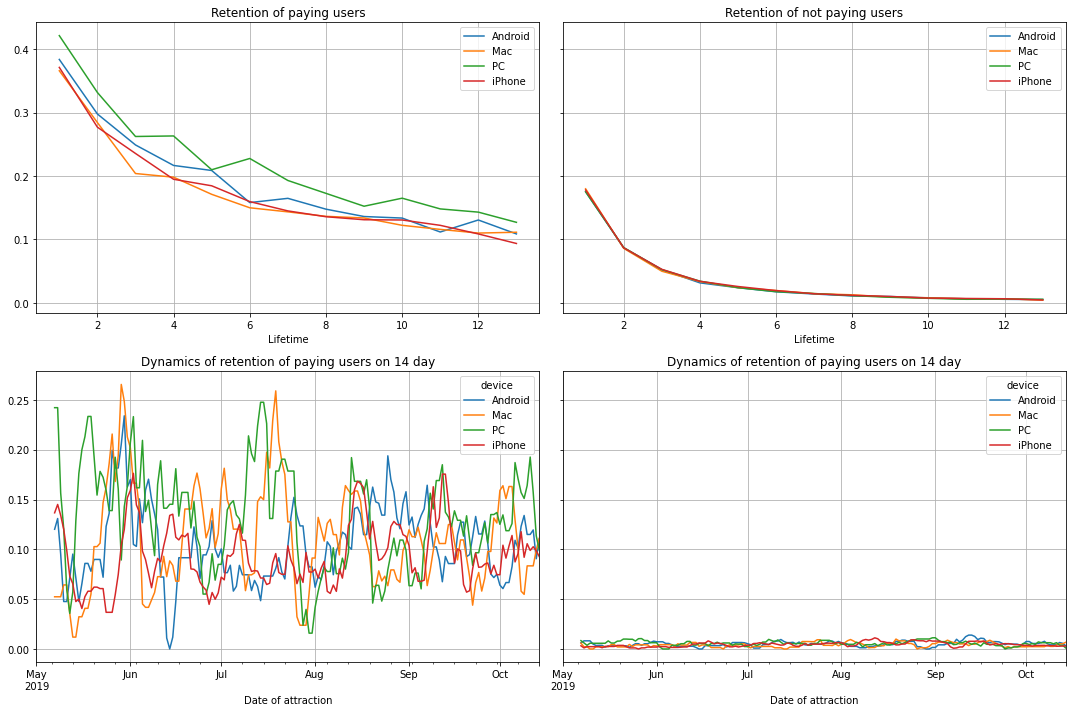

In [52]:
# user retention by device
retention_raw,retention,retention_history=get_retention(
    profiles,
    visits,
    observation_date,
    14,
    dimensions=['device'])
plot_retention(retention, retention_history, 14, window=7)

On average, PC users are the most retained.

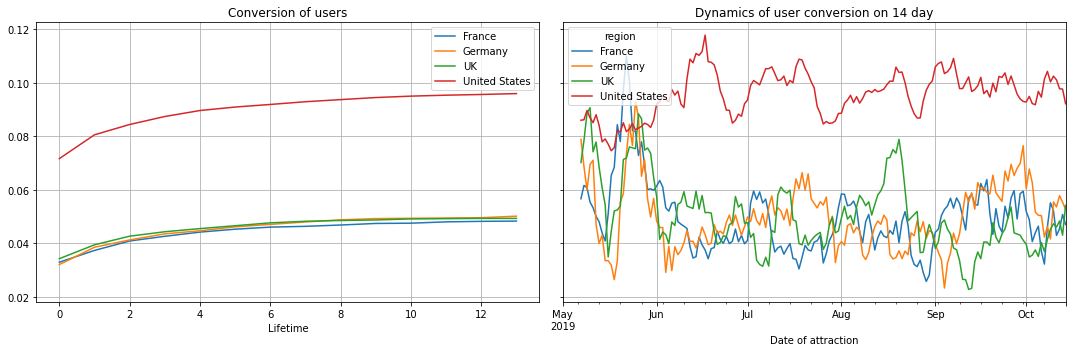

In [53]:
# user conversion by region
conversion_raw,conversion,conversion_history=get_conversion(
    profiles,
    orders,
    observation_date,
    14,
    dimensions=['region'])
plot_conversion(conversion, conversion_history, 14, window=7)

Although US users are poorly retained, they convert better than others.

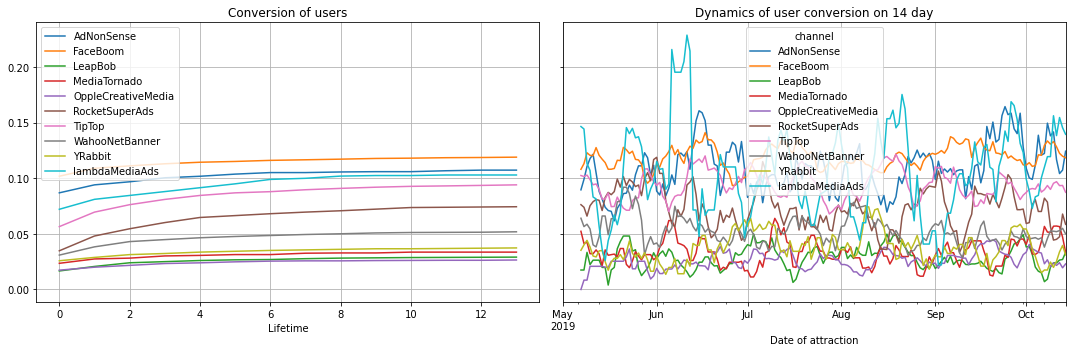

In [54]:
# conversion of users by acquisition channels
conversion_raw,conversion,conversion_history=get_conversion(
    profiles,
    orders,
    observation_date,
    14,
    dimensions=['channel'])
plot_conversion(conversion, conversion_history, 14, window=7)

Reverse logic and with channels of attraction. 'Faceboom' converts just fine too.

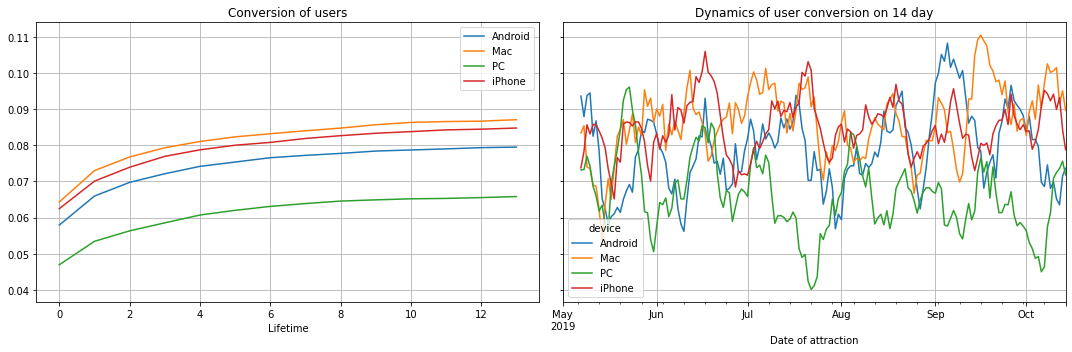

In [55]:
# conversion of users by acquisition channels
conversion_raw,conversion,conversion_history=get_conversion(
    profiles,
    orders,
    observation_date,
    14,
    dimensions=['device'])
plot_conversion(conversion, conversion_history, 14, window=7)

PC users are the best retained but also the worst converting.

In [56]:
# average number of sessions per user
visits['session_month'] = visits['session_start'].dt.month
# find the number of sessions and the number of users
sessions_per_user = visits.groupby(['session_month']).agg(
    {'user_id': ['count', 'nunique']}
)

# rename columns
sessions_per_user.columns = ['n_sessions', 'n_users']
# divide the number of sessions by the number of users
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)

print(sessions_per_user) 

               n_sessions  n_users  sessions_per_user
session_month                                        
5                   45765    27111           1.688060
6                   44623    26042           1.713501
7                   47970    26672           1.798515
8                   55996    31064           1.802601
9                   56628    31871           1.776788
10                  58919    31175           1.889944


In [57]:
# average number of sessions per paying user
visits['payer'] = visits['user_id'].isin(orders['user_id'].unique())
pay = visits[visits['payer']==True]


pay['session_month'] = pay['session_start'].dt.month
# find the number of sessions and the number of users
sessions_per_user = pay.groupby(['session_month']).agg(
    {'user_id': ['count', 'nunique']}
)

# rename columns
sessions_per_user.columns = ['n_sessions', 'n_users']
# divide the number of sessions by the number of users
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)

print(sessions_per_user) 

               n_sessions  n_users  sessions_per_user
session_month                                        
5                    5804     1321           4.393641
6                    9594     2366           4.054945
7                   12842     3120           4.116026
8                   15008     3995           3.756696
9                   16627     4839           3.436041
10                  19499     5511           3.538196


/tmp/ipykernel_68/772145801.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay['session_month'] = pay['session_start'].dt.month


In [58]:
# calculate the average session duration
visits['session_duration_sec'] = (
    visits['session_end'] - visits['session_start']
).dt.seconds

print(visits['session_duration_sec'].mean()) 

1800.0908677287264


The average session length is about 30 minutes - pretty good.

In [59]:
pay['session_duration_sec'] = (
    pay['session_end'] - pay['session_start']
).dt.seconds

print(pay['session_duration_sec'].mean()) 

1799.245773175095


/tmp/ipykernel_68/3409051156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay['session_duration_sec'] = (


For paying ASL users the same

# Step 6. Conclusion


General conclusions:
     1. There are problems with advertising in the USA - it does not pay off as it was supposed to. Also in the US, problems with user retention. As a result, revenue falls.
     2. A lot of money has been invested in the acquisition channel 'Tiptop', which has been making big losses so far.
     3. The 'Faceboom' acquisition channel is poorly retained but converts well.
     4. PC users get the best payback as advertising costs are lower.
     5. In Europe, users are quite well retained, but so far they are not converting quite well. It is worth thinking about buying advertising in these countries.
     6. On average, one user spends a maximum of 1-2 sessions in the application per month, and paying 3-4. For an entertainment application, there is room to grow.
     7. The average duration of a session is about 30 minutes.
Recommendations:
     1. If the 'Tiptop' advertising channel does not start to make a profit, we should stop investing money there.
     2. It is worth investing money in advertising more evenly, rather than pouring a lot of money into one channel.
    3. The 'lambdaMediaAds' channel brings in the most profit, and the 'YRabiit' channel has the highest ROI, as it has very cheap advertising. It is worth thinking not about where to invest money, but how to reduce costs.
     4. By device, PC users have the highest retention, and MAC users have the highest conversion. Perhaps a more user-friendly application has been made for the computer, and it is worth investing in improving the application for smartphones.
     5. There is potential for application in Europe. Users are well retained, and even though they are few, they bring good profits.
     